<a href="https://colab.research.google.com/github/priya-m2004/HARPY-AEROSPACE-INTERNSHIP-PROJECT-/blob/main/2022506015_PRIYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DNN MOVIE LENS MODEL


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.6 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.BZVUWT_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.7ORCQJ_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
Epoch 1/10
10/10 [==============================] - 38s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0046 - factorized_top_k/top_10_categorical_accuracy: 0.0091 - factorized_top_k/top_50_categorical_accuracy: 0.0505 - factorized_top_k/top_100_categorical_accuracy: 0.0967 - loss: 70668.6186 - regularization_loss: 0.0000e+00 - total_loss: 70668.6186
Epoch 2/10
10/10 [==============================] - 31s 3s/step - factorized_top_k/top_1_categorical_accuracy: 8.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0049 - factorized_top_k/top_10_categorical_accuracy: 0.0109 - factorized_top_k/top_50_categorical_accuracy: 0.0532 - factorized_top_k/top_100_categorical_accuracy: 0.1044 - loss: 70139.0540 - regularization_loss: 0.0000e+00 - total_loss: 70139.0540
Epoch 3/10
10/10 [=======

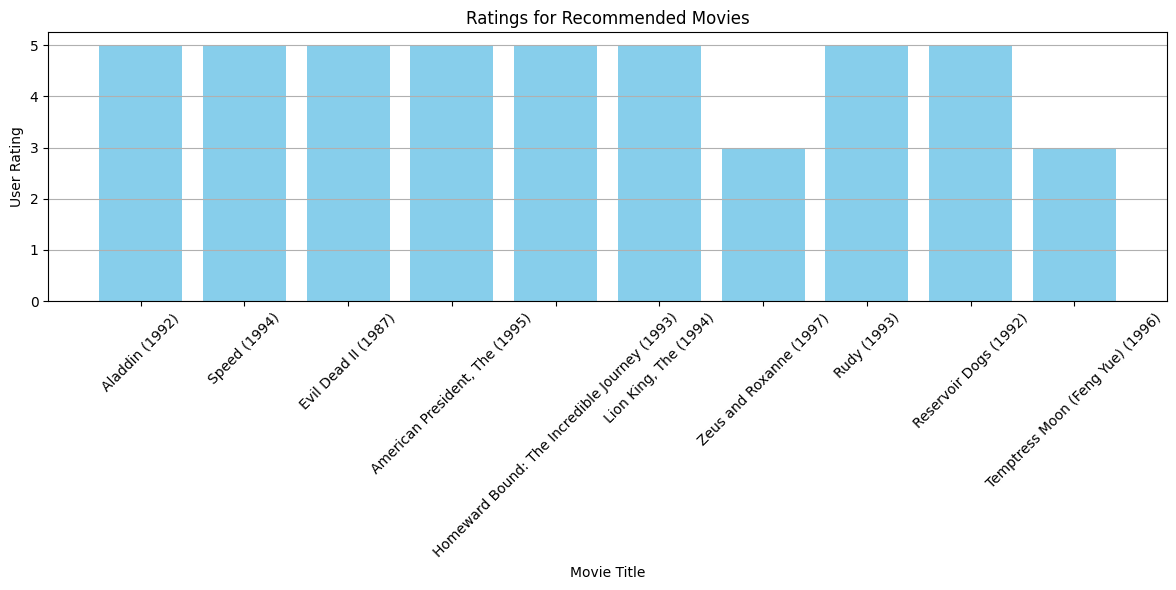

In [2]:
!pip install -q tensorflow-recommenders
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model with additional features.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the retrieval task with additional metrics.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Define the model.
class EnhancedMovieLensModel(tfrs.Model):
    def _init_(self, user_model, movie_model, task):
        super()._init_()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

# Create and compile the model.
model = EnhancedMovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model.
model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations.
_, titles = index(np.array(["55"]))
print(f"Top 3 recommendations for user 55: {titles[0, :3]}")
# Get recommendations for a different user.
_, titles = index(np.array(["100"]))
print(f"Top 3 recommendations for user 100: {titles[0, :3]}")


.Enhanced MovieLens Two-Tower Model




In [5]:
!pip install -q tensorflow-recommenders
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model with additional features.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the retrieval task with additional metrics.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Define the model.
class EnhancedMovieLensModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

# Create and compile the model.
model = EnhancedMovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model.
model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations.
_, titles = index(np.array(["55"]))
print(f"Top 3 recommendations for user 55: {titles[0, :3]}")
# Get recommendations for a different user.
_, titles = index(np.array(["100"]))
print(f"Top 3 recommendations for user 100: {titles[0, :3]}")


Epoch 1/10
25/25 [==============================] - 19s 669ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0067 - factorized_top_k/top_10_categorical_accuracy: 0.0134 - loss: 32244.1462 - regularization_loss: 0.0000e+00 - total_loss: 32244.1462
Epoch 2/10
25/25 [==============================] - 17s 664ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0064 - factorized_top_k/top_10_categorical_accuracy: 0.0142 - loss: 31443.0418 - regularization_loss: 0.0000e+00 - total_loss: 31443.0418
Epoch 3/10
25/25 [==============================] - 17s 668ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0087 - factorized_top_k/top_10_categorical_accuracy: 0.0183 - loss: 30919.1746 - regularization_loss: 0.0000e+00 - total_loss: 30919.1746
Epoch 4/10
25/25 [==============================] - 20s 796ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0119 - factorized_top_k/top_10_categorical_accuracy: 0.0255 - loss: 30554.6342 - regularization_loss: 0.0000e+00 - total_l

Graph Neural Network (GNN)-based MovieLens Model



Epoch 1/10
25/25 [==============================] - 19s 665ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0056 - factorized_top_k/top_10_categorical_accuracy: 0.0115 - loss: 32315.0828 - regularization_loss: 0.0000e+00 - total_loss: 32315.0828
Epoch 2/10
25/25 [==============================] - 16s 635ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0064 - factorized_top_k/top_10_categorical_accuracy: 0.0131 - loss: 31430.2682 - regularization_loss: 0.0000e+00 - total_loss: 31430.2682
Epoch 3/10
25/25 [==============================] - 16s 651ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0079 - factorized_top_k/top_10_categorical_accuracy: 0.0168 - loss: 30855.8694 - regularization_loss: 0.0000e+00 - total_loss: 30855.8694
Epoch 4/10
25/25 [==============================] - 17s 661ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0115 - factorized_top_k/top_10_categorical_accuracy: 0.0243 - loss: 30511.4345 - regularization_loss: 0.0000e+00 - total_l

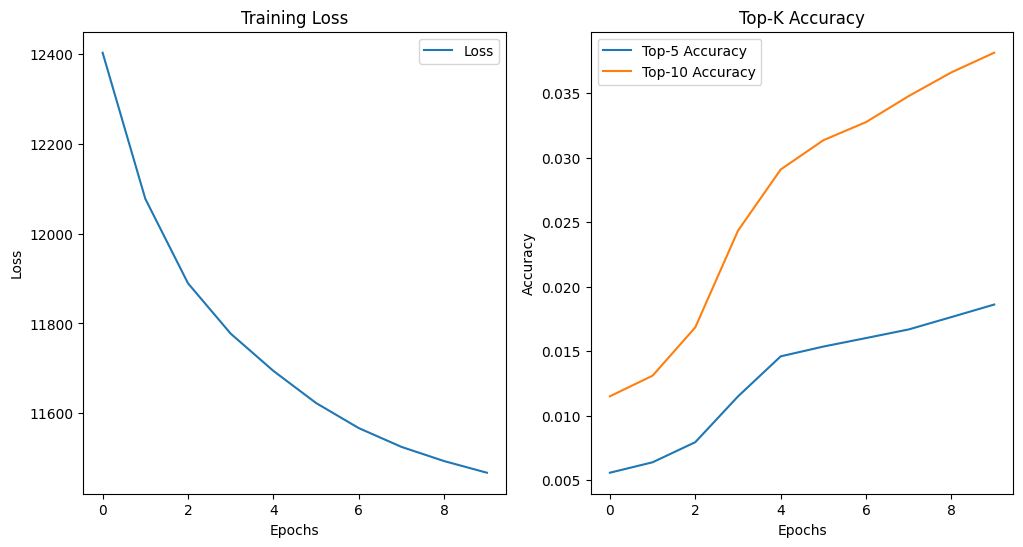

In [13]:


!pip install -q tensorflow-recommenders matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model with additional features.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

# Convert the movie titles to a TensorFlow Dataset
movies = tf.data.Dataset.from_tensor_slices(list(movies))

# Define the GNN layer
class GNNLayer(layers.Layer):
    def __init__(self, units):
        super(GNNLayer, self).__init__()
        self.units = units
        self.dense = layers.Dense(units)

    def call(self, inputs, edge_index):
        x = inputs
        row, col = edge_index[:, 0], edge_index[:, 1]
        out = tf.math.unsorted_segment_sum(x[col], row, num_segments=tf.shape(x)[0])
        return self.dense(out)

class GNNModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def call(self, features):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        edge_index = tf.convert_to_tensor([features["user_id"], features["movie_title"]])
        gnn_layer = GNNLayer(64)
        user_embeddings = gnn_layer(user_embeddings, edge_index)
        movie_embeddings = gnn_layer(movie_embeddings, edge_index)
        return self.task(user_embeddings, movie_embeddings)

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

# Define user and movie models
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the task
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Create and compile the model
model = GNNModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model and capture the training history
history = model.fit(ratings.batch(4096), epochs=10, verbose=1)

# Set up brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations for a specific user
_, titles = index(np.array(["55"]))
print(f"Top 3 recommendations for user 55: {titles[0, :3]}")

# Get recommendations for another user
_, titles = index(np.array(["100"]))
print(f"Top 3 recommendations for user 100: {titles[0, :3]}")

# Plot the training loss and top-k accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot top-5 and top-10 accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label='Top-5 Accuracy')
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'], label='Top-10 Accuracy')
plt.title('Top-K Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
